In [1]:
%load_ext cuml.accel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

[2025-04-10 19:01:34.195] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-10 19:02:01.559] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-10 19:02:01.688] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-10 19:02:01.688] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
df = pd.read_csv('Physical_Activity_Monitoring_unlabeled.csv')
df.head()

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 53 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float64
 1   handTemperature    530560 non-null  float64
 2   handAcc16_1        530560 non-null  float64
 3   handAcc16_2        530560 non-null  float64
 4   handAcc16_3        530560 non-null  float64
 5   handAcc6_1         530560 non-null  float64
 6   handAcc6_2         530560 non-null  float64
 7   handAcc6_3         530560 non-null  float64
 8   handGyro1          530560 non-null  float64
 9   handGyro2          530560 non-null  float64
 10  handGyro3          530560 non-null  float64
 11  handMagne1         530560 non-null  float64
 12  handMagne2         530560 non-null  float64
 13  handMagne3         530560 non-null  float64
 14  handOrientation1   530560 non-null  float64
 15  handOrientation2   530560 non-null  float64
 16  ha

In [4]:
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [5]:
df_processing = df.drop(['subject_id'], axis=1)
df_processing.describe(include='all')

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
count,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,...,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000
mean,1593.538159,32.451221,-4.435286,3.241949,4.079375,-4.375896,3.218250,4.262513,-0.008852,0.028801,...,0.017766,-0.031911,0.002304,-28.756284,2.115624,14.723345,0.360159,-0.091093,0.303517,-0.173845
std,1243.906483,1.748202,7.035262,7.196676,3.816750,7.042194,6.838788,3.807580,1.155719,0.923322,...,0.957082,0.617365,2.031248,19.257865,22.200117,17.864799,0.300536,0.558067,0.343450,0.465192
min,37.660000,27.500000,-114.755000,-82.550900,-73.949700,-61.214700,-61.824200,-61.577100,-19.690500,-7.609010,...,-10.093500,-7.701040,-14.019600,-172.865000,-136.951000,-102.716000,0.000003,-0.954848,-0.876838,-0.997040
25%,475.500000,31.312500,-9.065130,0.725916,1.617070,-8.967270,0.732976,1.806570,-0.148494,-0.080412,...,-0.066380,-0.048469,-0.211924,-39.649700,-10.843100,2.385840,0.145729,-0.674639,0.007326,-0.579087
50%,827.610000,32.812500,-5.357500,3.118630,4.104990,-5.320320,3.156040,4.358560,-0.005077,0.004567,...,0.007644,-0.004780,0.000538,-26.524200,0.091426,16.487600,0.243944,0.000000,0.320291,-0.279768
75%,2876.990000,33.812500,0.367810,5.518940,6.842660,0.413684,5.556420,7.128920,0.125906,0.091399,...,0.059682,0.048142,0.032264,-14.556400,19.173600,25.914500,0.500755,0.409401,0.592794,0.242434
max,4007.730000,35.250000,60.912600,155.532000,78.480100,34.159400,62.259800,60.843700,22.960000,11.862600,...,12.256000,6.002540,14.482700,41.764800,92.867000,122.521000,1.000000,0.959538,0.920506,0.996105


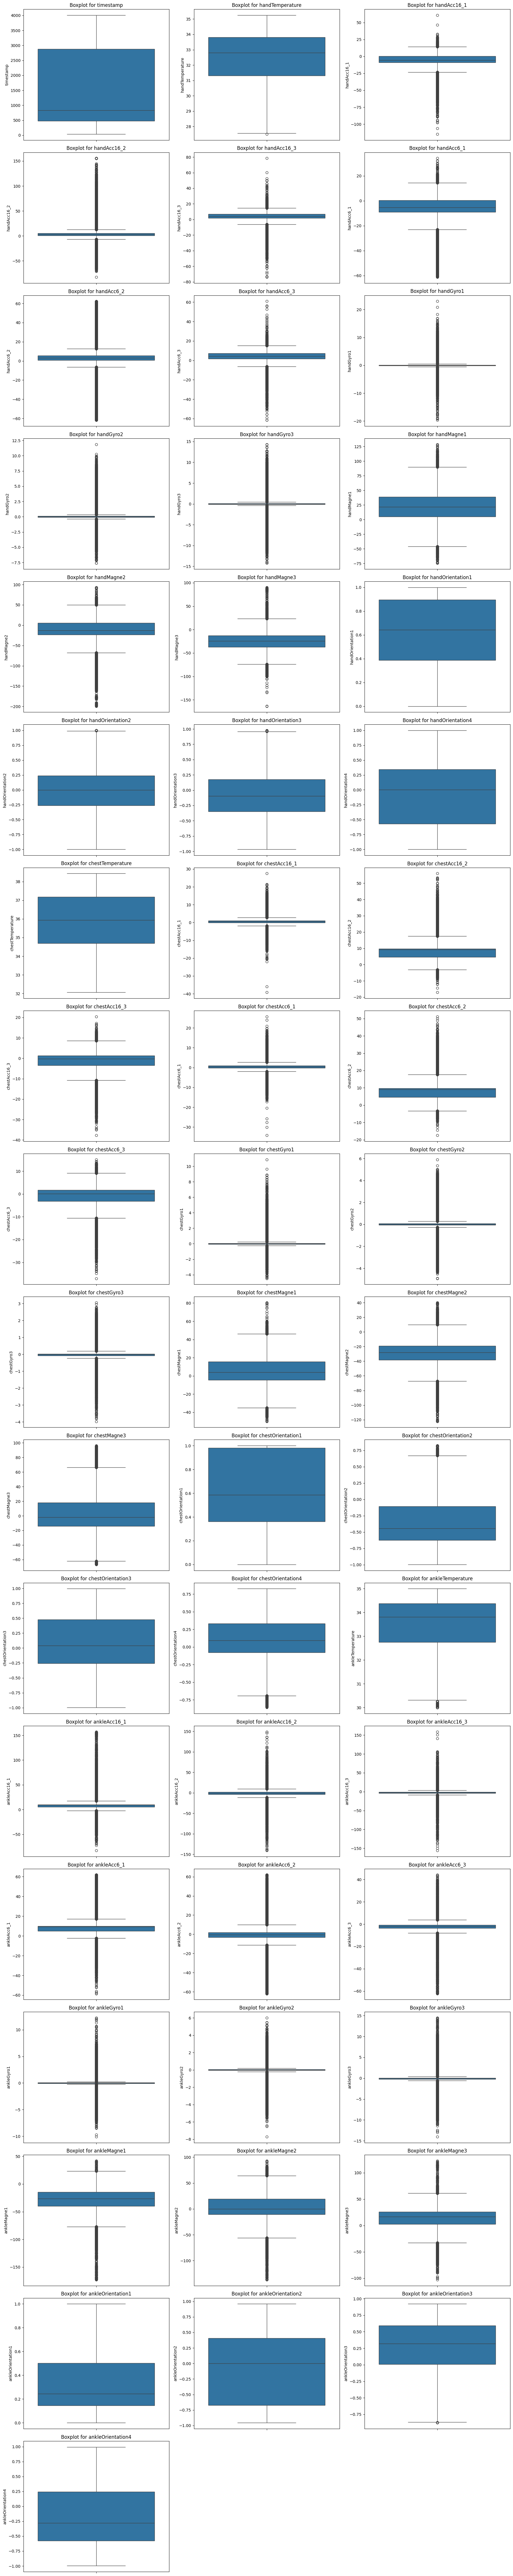

In [6]:
num_cols = len(df_processing.columns)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 5))

axes = axes.ravel()

for i, column in enumerate(df_processing.columns):
    sns.boxplot(data = df_processing[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

for i in range(num_cols, num_rows * 3):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Ряд колонок имеют существенные выбросы, что может негативно сказаться на процесс кластеризации. В первой иттерации попробуем сделать кластеризацию без таких признаков

In [7]:
df_processing = df_processing[['timestamp',
                               'handTemperature',
                               'handOrientation1',
                               'handOrientation2',
                               'handOrientation3',
                               'handOrientation4',
                               'chestTemperature',
                               'chestOrientation1',
                               'chestOrientation2',
                               'chestOrientation3',
                               'chestOrientation4',
                               'ankleTemperature',
                               'ankleOrientation1',
                               'ankleOrientation2',
                               'ankleOrientation3',
                               'ankleOrientation4']]
df_processing.corr()

,timestamp,handTemperature,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
timestamp,1.000000,-0.501633,-0.135785,0.006157,-0.288947,-0.062485,0.020391,-0.455640,-0.357111,-0.110940,-0.153992,-0.007226,0.263888,0.092618,0.143089,0.348652
handTemperature,-0.501633,1.000000,-0.057050,-0.023294,0.018017,-0.060855,0.698076,0.146150,0.127322,0.098668,0.063821,0.407986,-0.242153,-0.051327,-0.085329,-0.103918
handOrientation1,-0.135785,-0.057050,1.000000,-0.218677,0.186430,0.321893,-0.302897,0.449787,0.313950,-0.405893,-0.317103,-0.138114,0.450321,-0.112863,-0.034661,-0.227984
handOrientation2,0.006157,-0.023294,-0.218677,1.000000,-0.189919,-0.627468,0.106385,-0.171603,0.128455,0.305881,0.282468,0.088880,-0.081084,0.302350,-0.006941,0.281555
handOrientation3,-0.288947,0.018017,0.186430,-0.189919,1.000000,0.371122,-0.204973,0.566536,0.209463,-0.042758,0.033839,-0.091154,0.026595,0.146231,0.088622,-0.108031
handOrientation4,-0.062485,-0.060855,0.321893,-0.627468,0.371122,1.000000,-0.192642,0.319648,-0.090638,-0.324093,-0.246968,-0.148225,0.129786,-0.119625,0.252326,-0.258130
chestTemperature,0.020391,0.698076,-0.302897,0.106385,-0.204973,-0.192642,1.000000,-0.226279,-0.161741,0.076605,0.021492,0.530878,-0.240815,0.002225,0.036129,0.104044
chestOrientation1,-0.455640,0.146150,0.449787,-0.171603,0.566536,0.319648,-0.226279,1.000000,0.419822,-0.100455,-0.004167,-0.166518,0.332512,0.104719,-0.096041,-0.168561
chestOrientation2,-0.357111,0.127322,0.313950,0.128455,0.209463,-0.090638,-0.161741,0.419822,1.000000,0.026950,0.035296,-0.039359,0.279941,0.136079,-0.215949,-0.110996
chestOrientation3,-0.110940,0.098668,-0.405893,0.305881,-0.042758,-0.324093,0.076605,-0.100455,0.026950,1.000000,0.905939,0.057530,-0.307079,0.198633,-0.088001,0.154220


<Axes: >

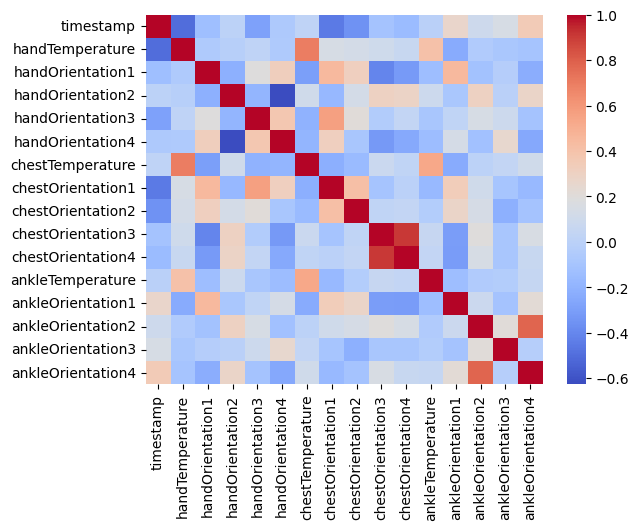

In [8]:
sns.heatmap(df_processing.corr(), cmap='coolwarm')

Наблюдается мультиколлинеарность, попробуем произвести кластеризацию без chest_temp, chest_orient4 и ankle_orient4

In [9]:
df_processing.drop(['chestTemperature', 'chestOrientation4', 'ankleOrientation4'], axis=1, inplace = True)

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_processing)

In [11]:
_, df_scaled_10_percent, _, _ = train_test_split(
    df_scaled, df_scaled, test_size=0.1, random_state=42
)

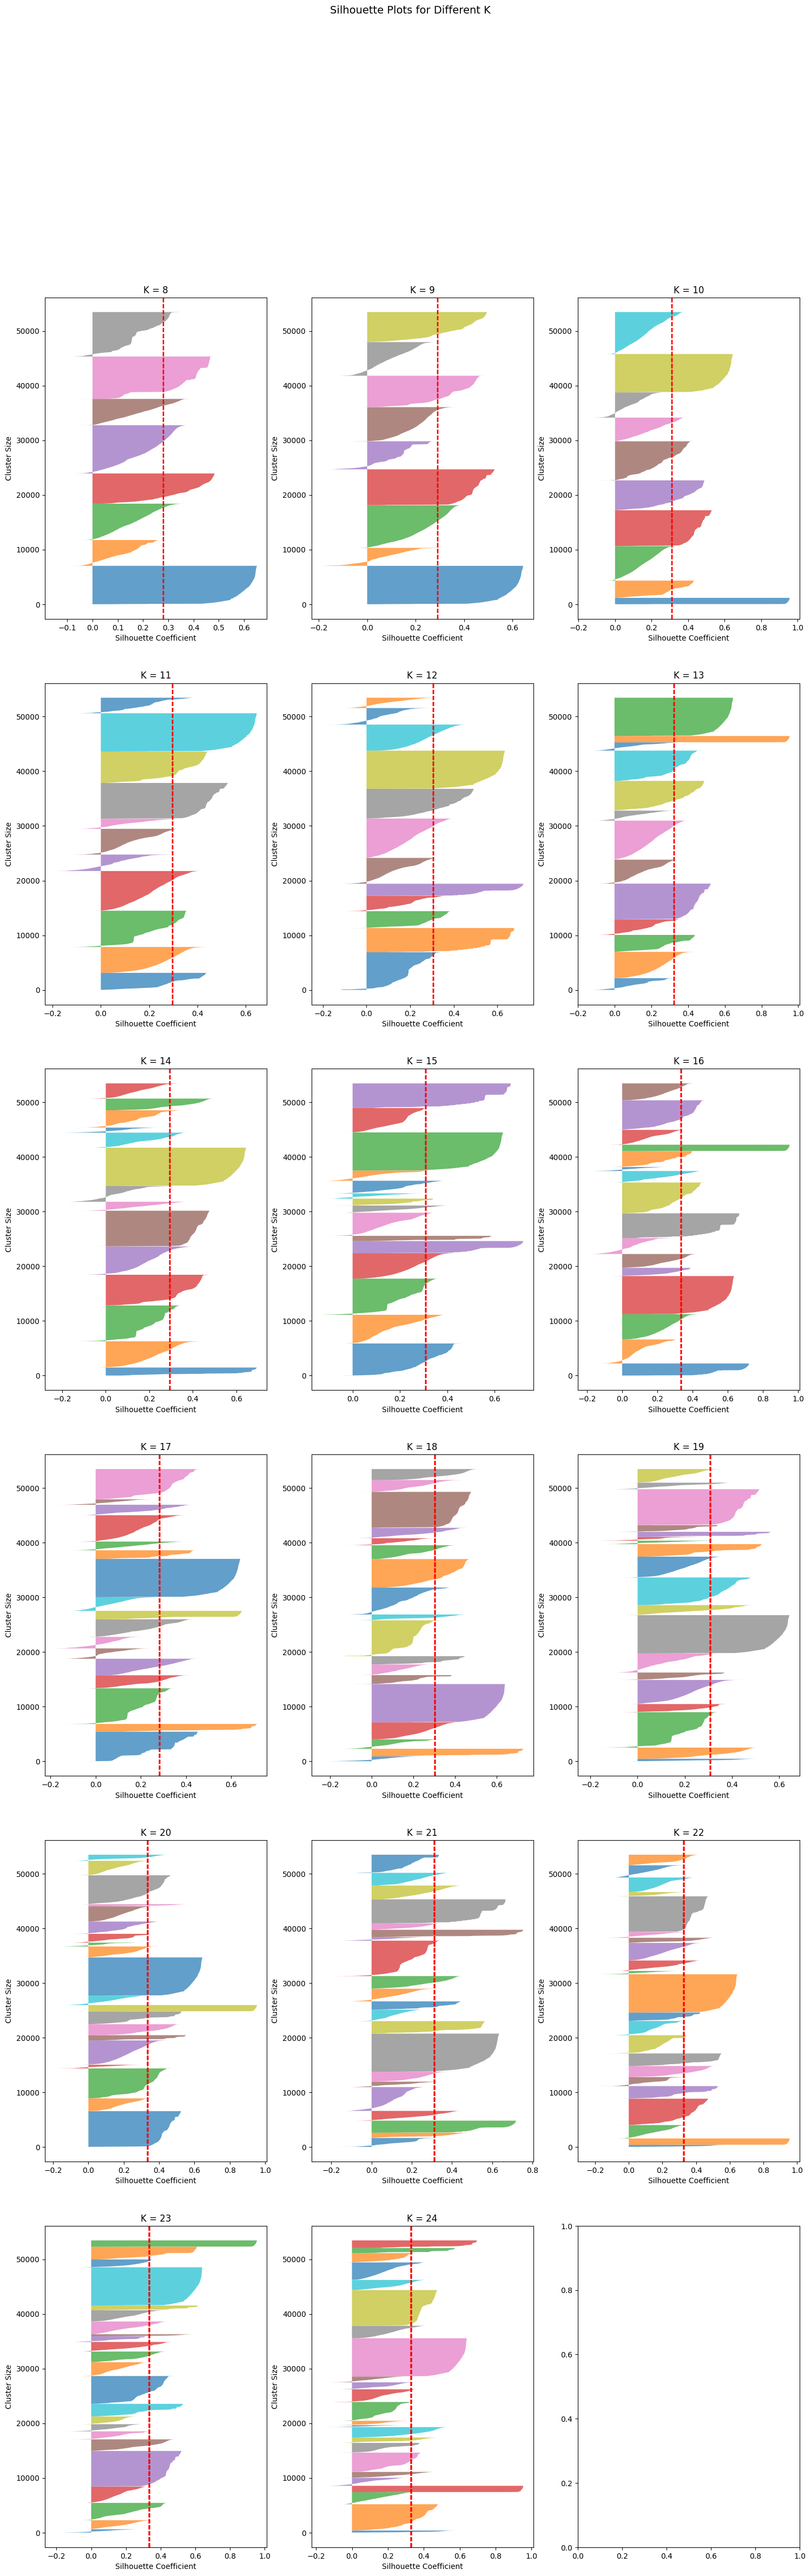

In [14]:
n_clusters_range = range(8, 25)
n_rows = (len(n_clusters_range) + 2) // 3
n_cols = 3

silhouette_scores = []
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows* 9))


for idx, n_clusters in enumerate(n_clusters_range):
  row_idx = idx // n_cols
  col_idx = idx % n_cols

  ax = axes[row_idx, col_idx]

  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  cluster_labels = kmeans.fit_predict(df_scaled_10_percent)

  score = silhouette_score(df_scaled_10_percent, cluster_labels)
  sample_silhouette_values = silhouette_samples(df_scaled_10_percent, cluster_labels)

  silhouette_scores.append(score)

  y_lower, y_upper = 0, 0
  ax.set_title(f"K = {n_clusters}")

  for i in range(n_clusters):
    cluster_silhouette_vals = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        alpha=0.7
        )
    y_lower = y_upper

    ax.axvline(score, linestyle="--", color="red")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Size")

plt.suptitle("Silhouette Plots for Different K", fontsize=14)
plt.show()

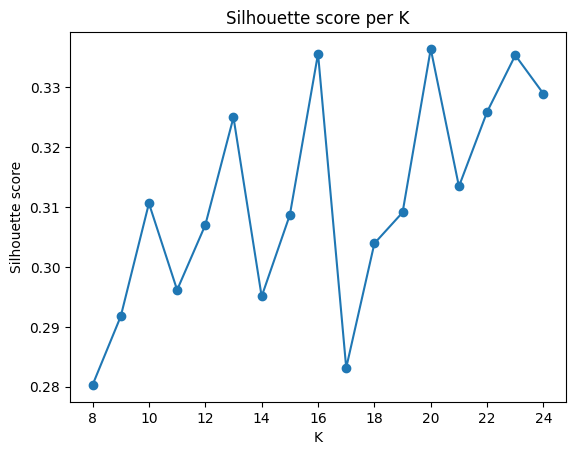

In [16]:
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score per K')
plt.show()

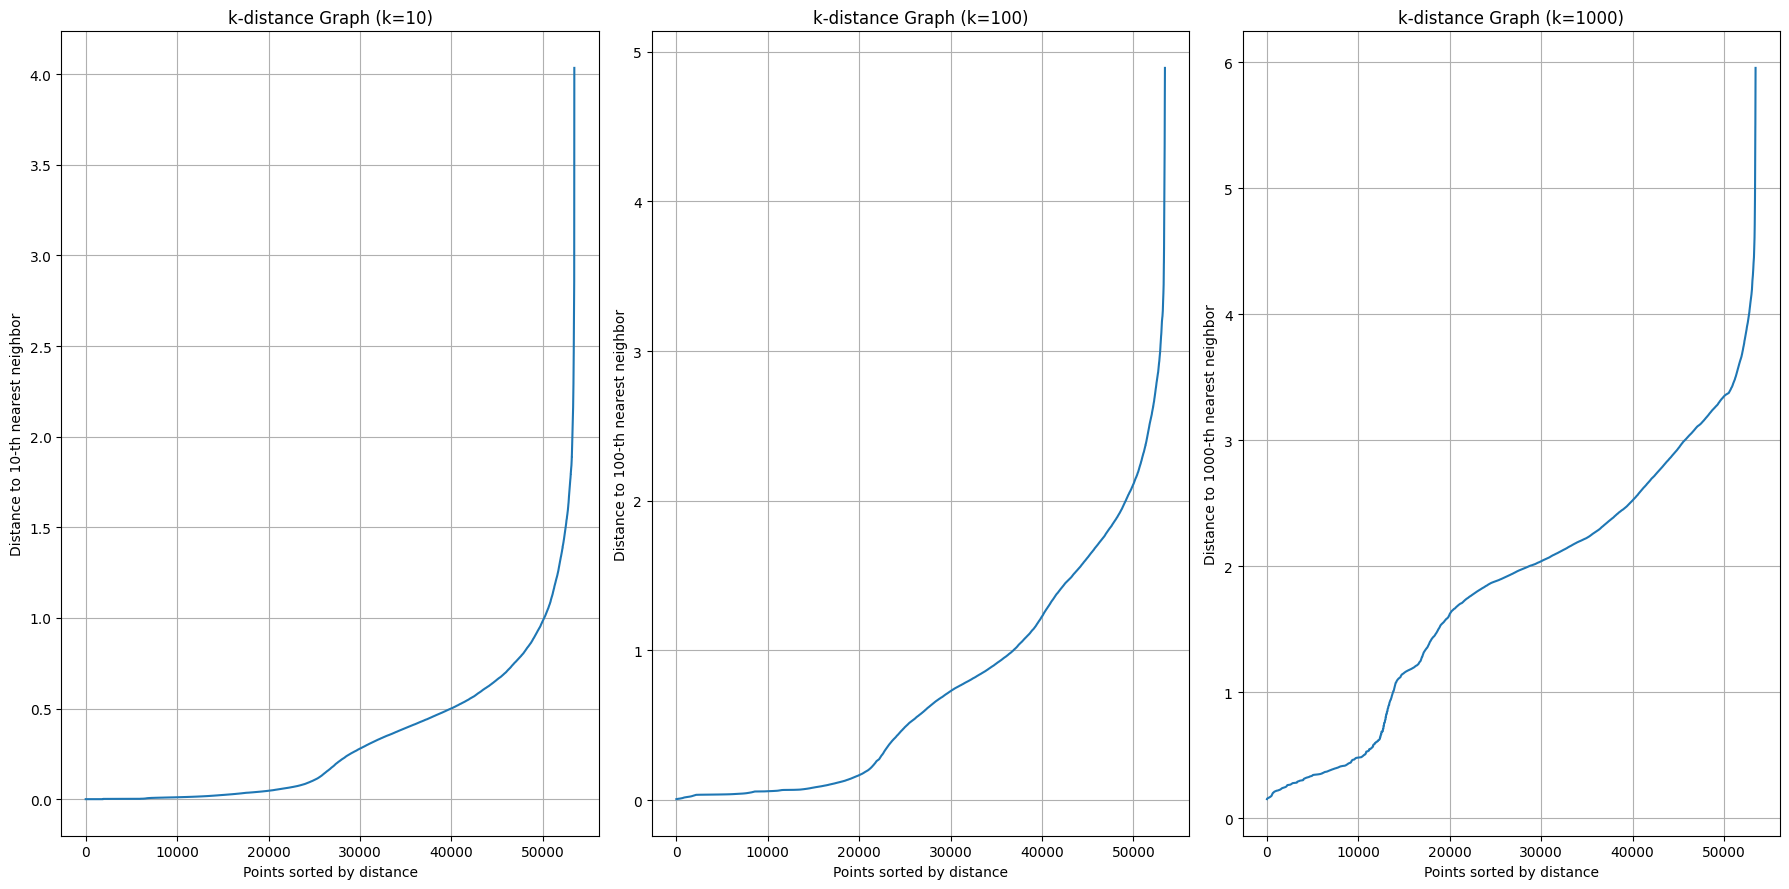

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

for i, k in enumerate([10, 100, 1000]):
  X_scaled = df_scaled_10_percent
  neighbors = NearestNeighbors(n_neighbors=k)
  neighbors_fit = neighbors.fit(X_scaled)
  distances, _ = neighbors_fit.kneighbors(X_scaled)
  distances = np.sort(distances[:, k - 1], axis=0)

  axes[i].plot(distances)
  axes[i].set_title(f'k-distance Graph (k={k})')
  axes[i].set_xlabel('Points sorted by distance')
  axes[i].set_ylabel(f'Distance to {k}-th nearest neighbor')
  axes[i].grid(True)


plt.tight_layout()
plt.show()

In [19]:
scores = []
silhouette_values = []
cluster_nums = []

best_score = -1
best_params = {'eps': None, 'min_samples': None}

samples = [10, 100, 1000]
eps_values = [0.5, 1.0, 2.0, 3.5]

for min_samples in samples:
  for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    if len(set(labels)) <= 1:
      continue

    cluster_nums.append(len(set(labels)))
    score = silhouette_score(X_scaled, labels)
    value = silhouette_samples(X_scaled, labels)
    scores.append(score)
    silhouette_values.append(value)

    if score > best_score:
       best_score = score
       best_params = {'eps': eps, 'min_samples': min_samples}

print(f'\nЛучшие параметры: eps = {best_params["eps"]}, min_samples = {best_params["min_samples"]}')
print(f'Silhouette score: {best_score:.4f}')

[2025-04-10 19:34:12.955] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 47347 -> 40169. Using the larger integer type might result in better performance
[2025-04-10 19:35:13.794] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 47347 -> 40169. Using the larger integer type might result in better performance
[2025-04-10 19:36:13.835] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 47347 -> 40169. Using the larger integer type might result in better performance
[2025-04-10 19:37:20.913] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 47347 -> 40169. Using the larger integer type might result in better performance
[2025-04-10 19:38:30.352] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 47347 -> 40169. Using the larger integer type might result in better performance
[2025-04-10 19:39:32.271] [CUML] [warning] Batch size limited by the chosen integer type (4 byt

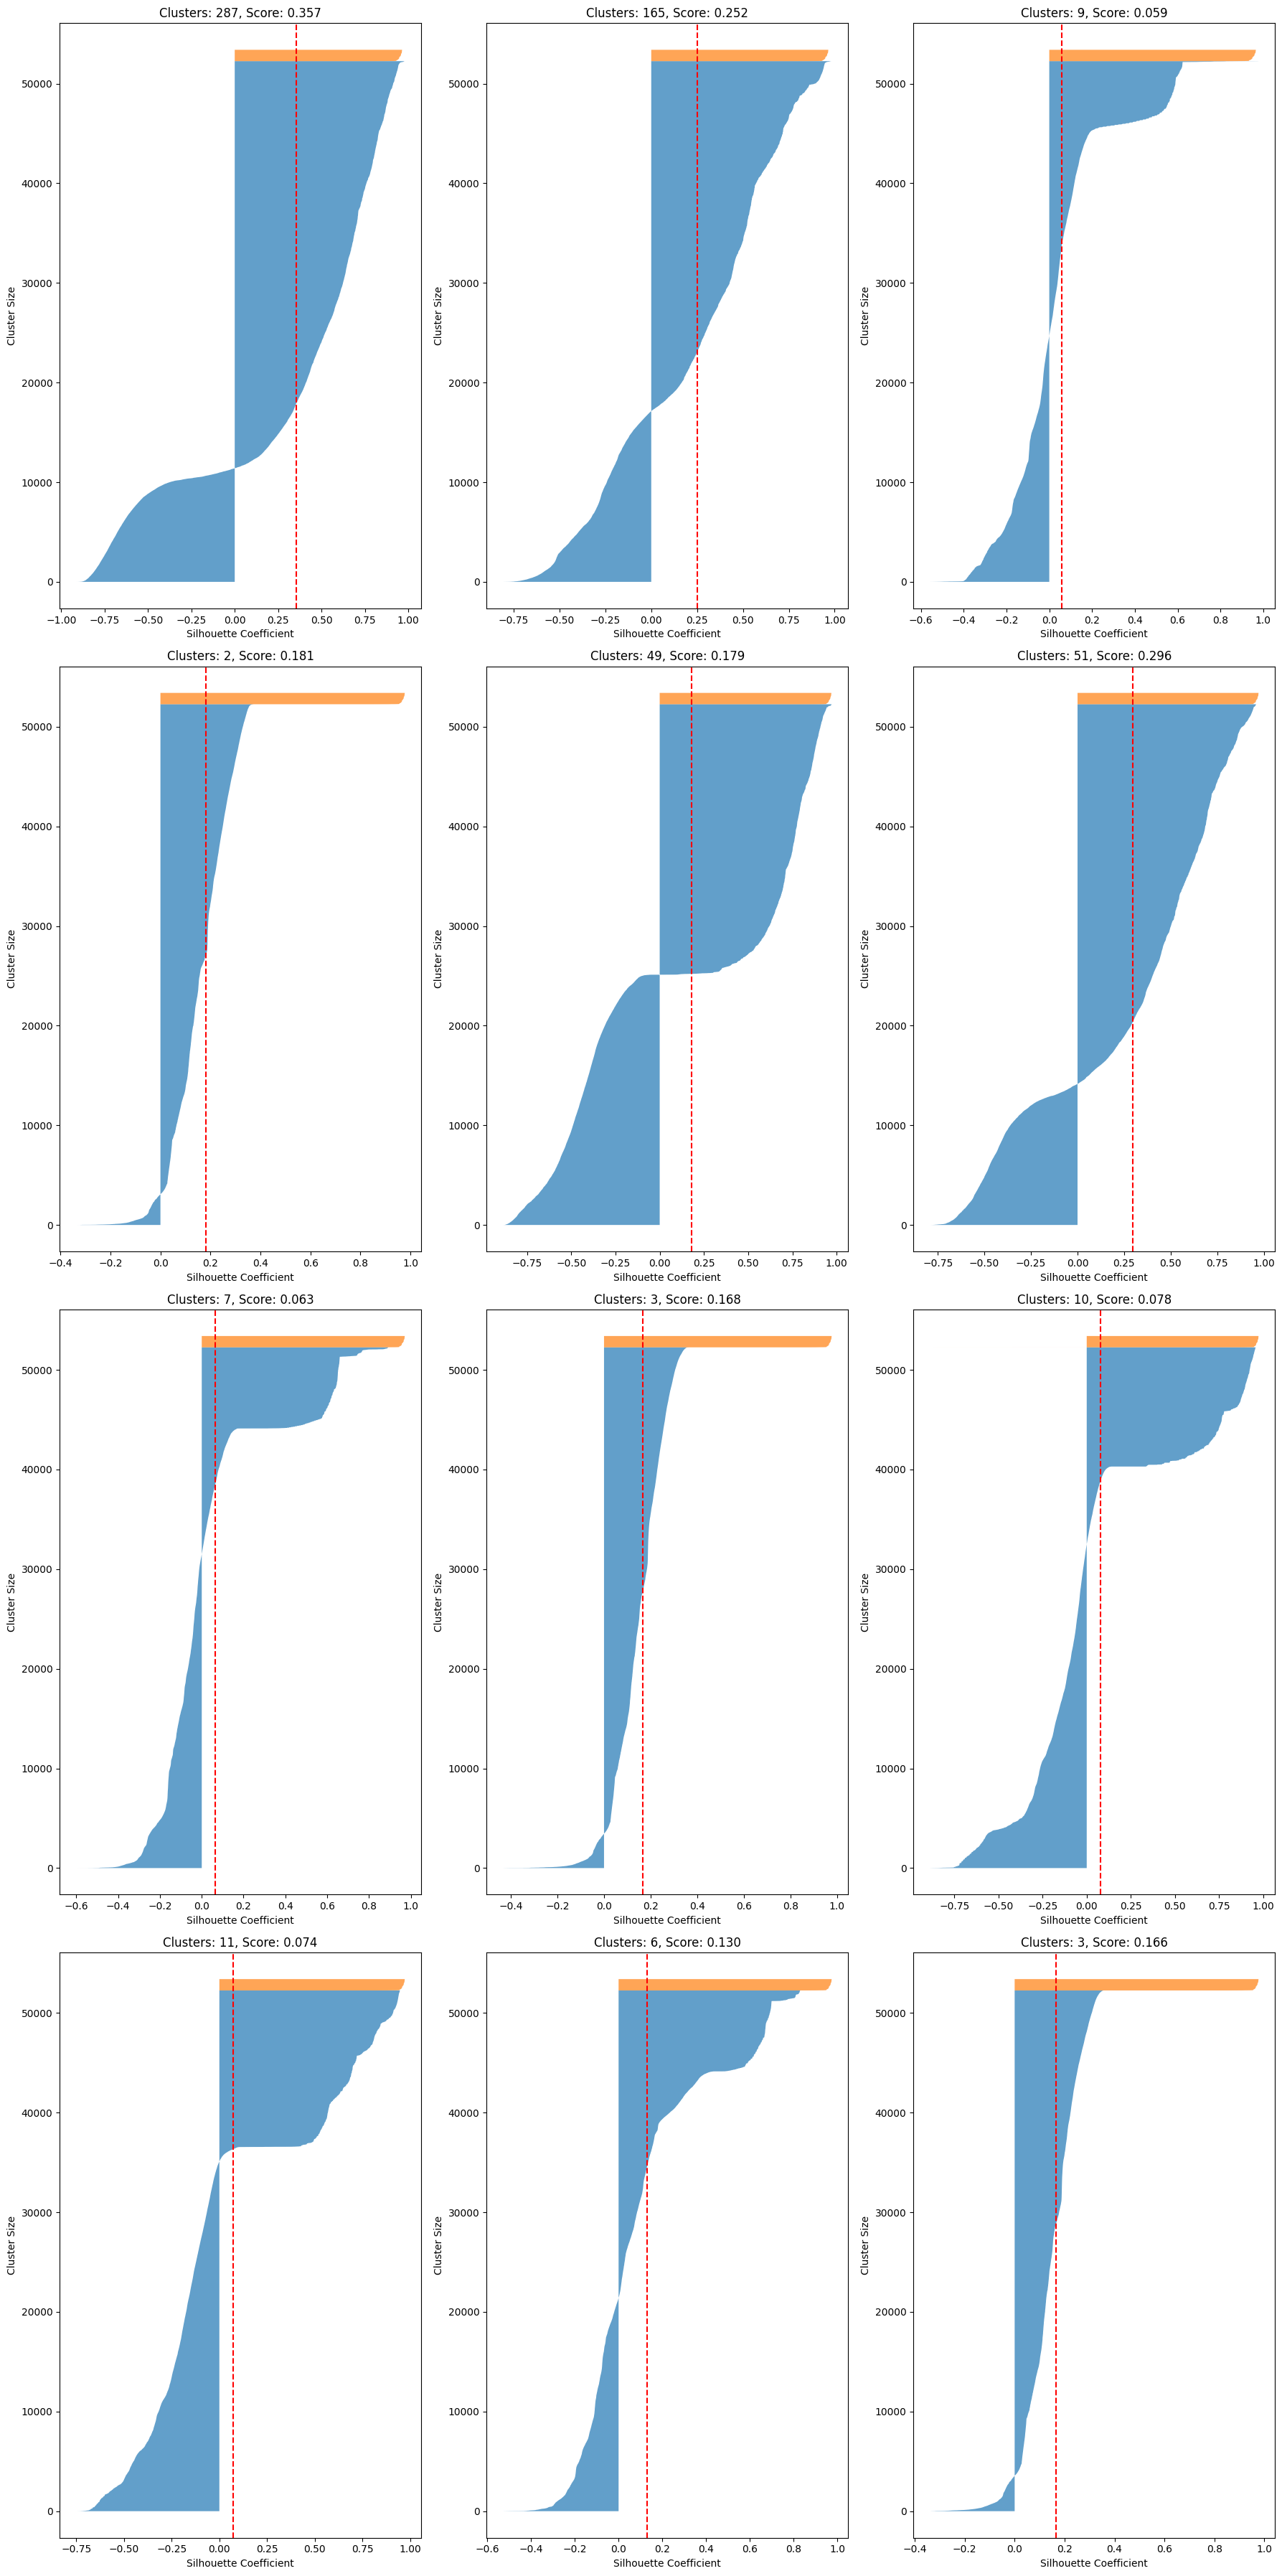

In [20]:
n_rows = (len(scores) + 2) // 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 9))

for i in range(len(scores)):
    row_idx = i // n_cols
    col_idx = i % n_cols

    ax = axes[row_idx, col_idx]

    y_lower = 0

    for j in range(cluster_nums[i]):
        cluster_silhouette_vals = silhouette_values[i][labels == j]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_vals,
            alpha=0.7
        )
        y_lower = y_upper

    ax.axvline(scores[i], linestyle="--", color="red")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Size")
    ax.set_title(f"Clusters: {cluster_nums[i]}, Score: {scores[i]:.3f}")

for i in range(len(scores), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Исходя из представленной информации, лучший вариант кластеризации выдал KMeans при K=16

In [22]:
kmeans_best = KMeans(n_clusters=16, random_state=42)
cluster_labels = kmeans_best.fit_predict(df_scaled)

df['cluster'] = cluster_labels
df['activityID'] = -1
unique_clusters = sorted(df['cluster'].unique())
for new_label, old_label in enumerate(unique_clusters, start=1):
    df.loc[df['cluster'] == old_label, 'activityID'] = new_label

submission = df[['activityID']].reset_index()
submission.columns = ['Index', 'activityID']
submission.to_csv('submission.csv', index=False)

# Подход с PCA

Выполняем предыдущий код до 5 ячейки (вкл.)

In [ ]:
scaler_pca = StandardScaler()
df_scaled_pca = scaler_pca.fit_transform(df_processing)
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(df_scaled_pca)

<ipython-input-14-c3ee62a49c19>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-14-c3ee62a49c19>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-14-c3ee62a49c19>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-14-c3ee62a49c19>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-14-c3ee62a49c19>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose

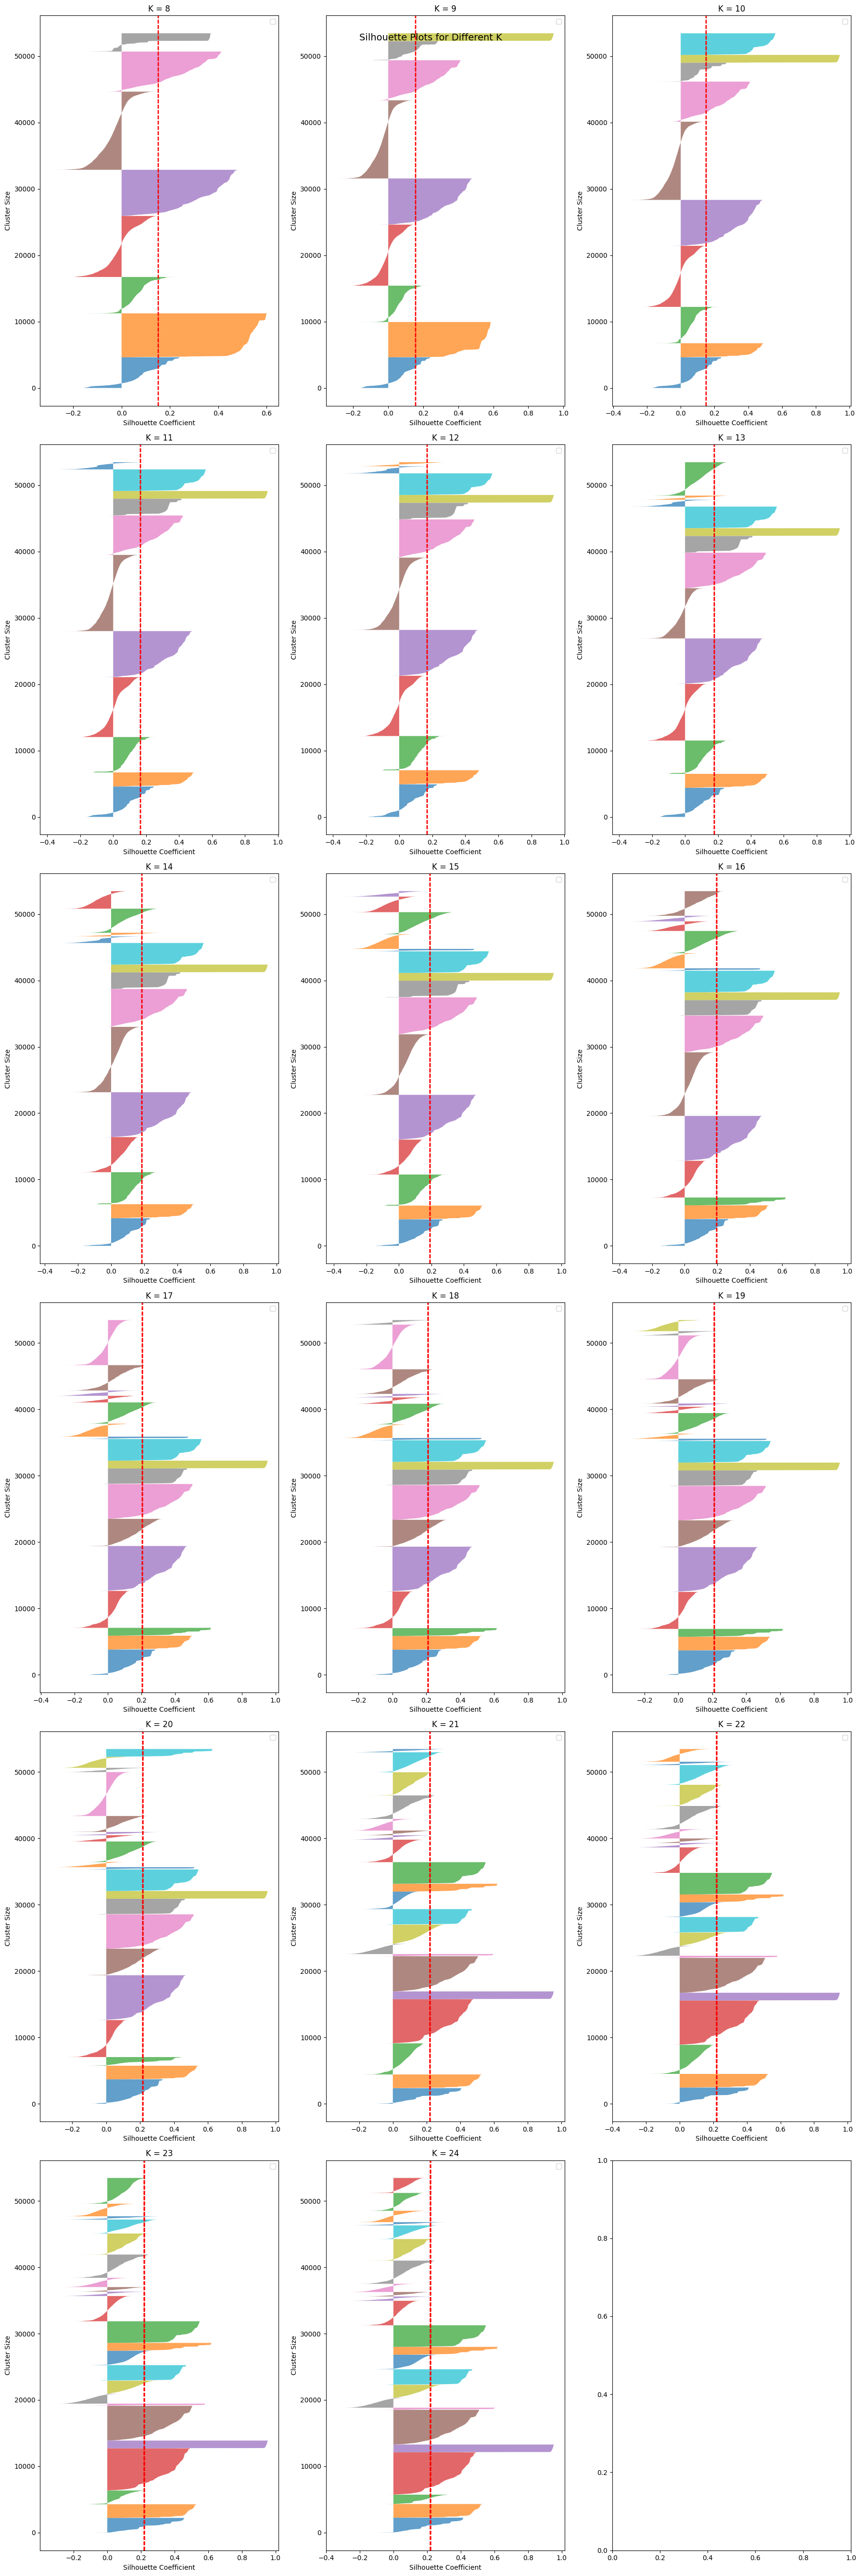

In [ ]:
_, X_pca_10_percent, _, _ = train_test_split(
    X_pca, X_pca, test_size=0.1, random_state=42
)

n_clusters_range = range(8, 25)
n_rows = (len(n_clusters_range) + 2) // 3
n_cols = 3

silhouette_scores = []
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows* 9))


for idx, n_clusters in enumerate(n_clusters_range):
  row_idx = idx // n_cols
  col_idx = idx % n_cols

  ax = axes[row_idx, col_idx]

  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  cluster_labels = kmeans.fit_predict(X_pca_10_percent)

  score = silhouette_score(X_pca_10_percent, cluster_labels)
  sample_silhouette_values = silhouette_samples(X_pca_10_percent, cluster_labels)

  silhouette_scores.append(score)

  y_lower, y_upper = 0, 0
  ax.set_title(f"K = {n_clusters}")

  for i in range(n_clusters):
    cluster_silhouette_vals = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        alpha=0.7
        )
    y_lower = y_upper

    ax.axvline(score, linestyle="--", color="red")
    ax.legend()
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Size")

plt.suptitle("Silhouette Plots for Different K", fontsize=14)
plt.tight_layout()
plt.show()